In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

In [128]:
import warnings

# Ignore all FutureWarnings
warnings.filterwarnings(action='ignore', category=FutureWarning)


In [129]:
# Load your data
df = pd.read_csv(r'C:\Users\James Stanley\Documents\GitHub\jamsydLibrary\approved_projects\XGBoostRegression\CME_DL_HE1!, 1D.csv', parse_dates=True, index_col='time')
df = df.sort_index(ascending=True)  # Ensure data is sorted by time

In [130]:
# Parameters
train_size = 252  # Initial training size in days
forecast_horizon = 5  # Days to forecast
lag = 1  # Number of lag days to use for predictions

In [131]:
df = np.exp(np.log(df[['close']]).diff(1))

In [132]:
df['firstlag']  = df[['close']].shift(-1)
df['secondlag'] = df[['close']].shift(-2)
df['thirdlag'] = df[['close']].shift(-3)
df['fourthlag'] = df[['close']].shift(-4)
df['fifthlag'] = df[['close']].shift(-5)


In [133]:
df = df.dropna(axis=0)

X_train = df[['firstlag']].iloc[0:train_size].dropna(axis=0)
X_test = df[['firstlag']].iloc[train_size:train_size+forecast_horizon].dropna(axis=0)

y_train = df[['close']].iloc[0:train_size].dropna(axis=0)
y_test  = df[['close']].iloc[train_size:train_size+forecast_horizon].dropna(axis=0)

# Assuming you have already defined and fitted your model:
model = XGBRegressor(n_estimators=100, learning_rate=0.1, objective='reg:squarederror')
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=10, verbose=False)


c:\Users\James Stanley\anaconda3\envs\fast-api-tutorial\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [134]:
def forecast(model, input_data, days=5):
    """
    Generate out-of-sample forecasts.
    """
    
    forecast = []
    current_input = input_data.copy()

    for _ in range(days):
        next_day_pred = model.predict(current_input.reshape(1, -1))[0]
        forecast.append(next_day_pred)
        current_input = np.roll(current_input, -1)
        current_input[-1] = next_day_pred

    return forecast

In [137]:
forecasts = []

# Forecast
latest_input = X_test.iloc[-1].values[-lag:]
forecast_values = forecast(model, latest_input, days=forecast_horizon)
forecasts.append(forecast_values)

# Append forecasts
forecasts.append(y_test.index.T)

# Creating dataframe
forecast_df = pd.DataFrame(forecasts).T

# Set index calue
forecast_df
forecast_df = forecast_df.set_index(1)
forecast_df.index.name = 'time'

df.rename(columns={0: 'forecast'}, inplace=True)


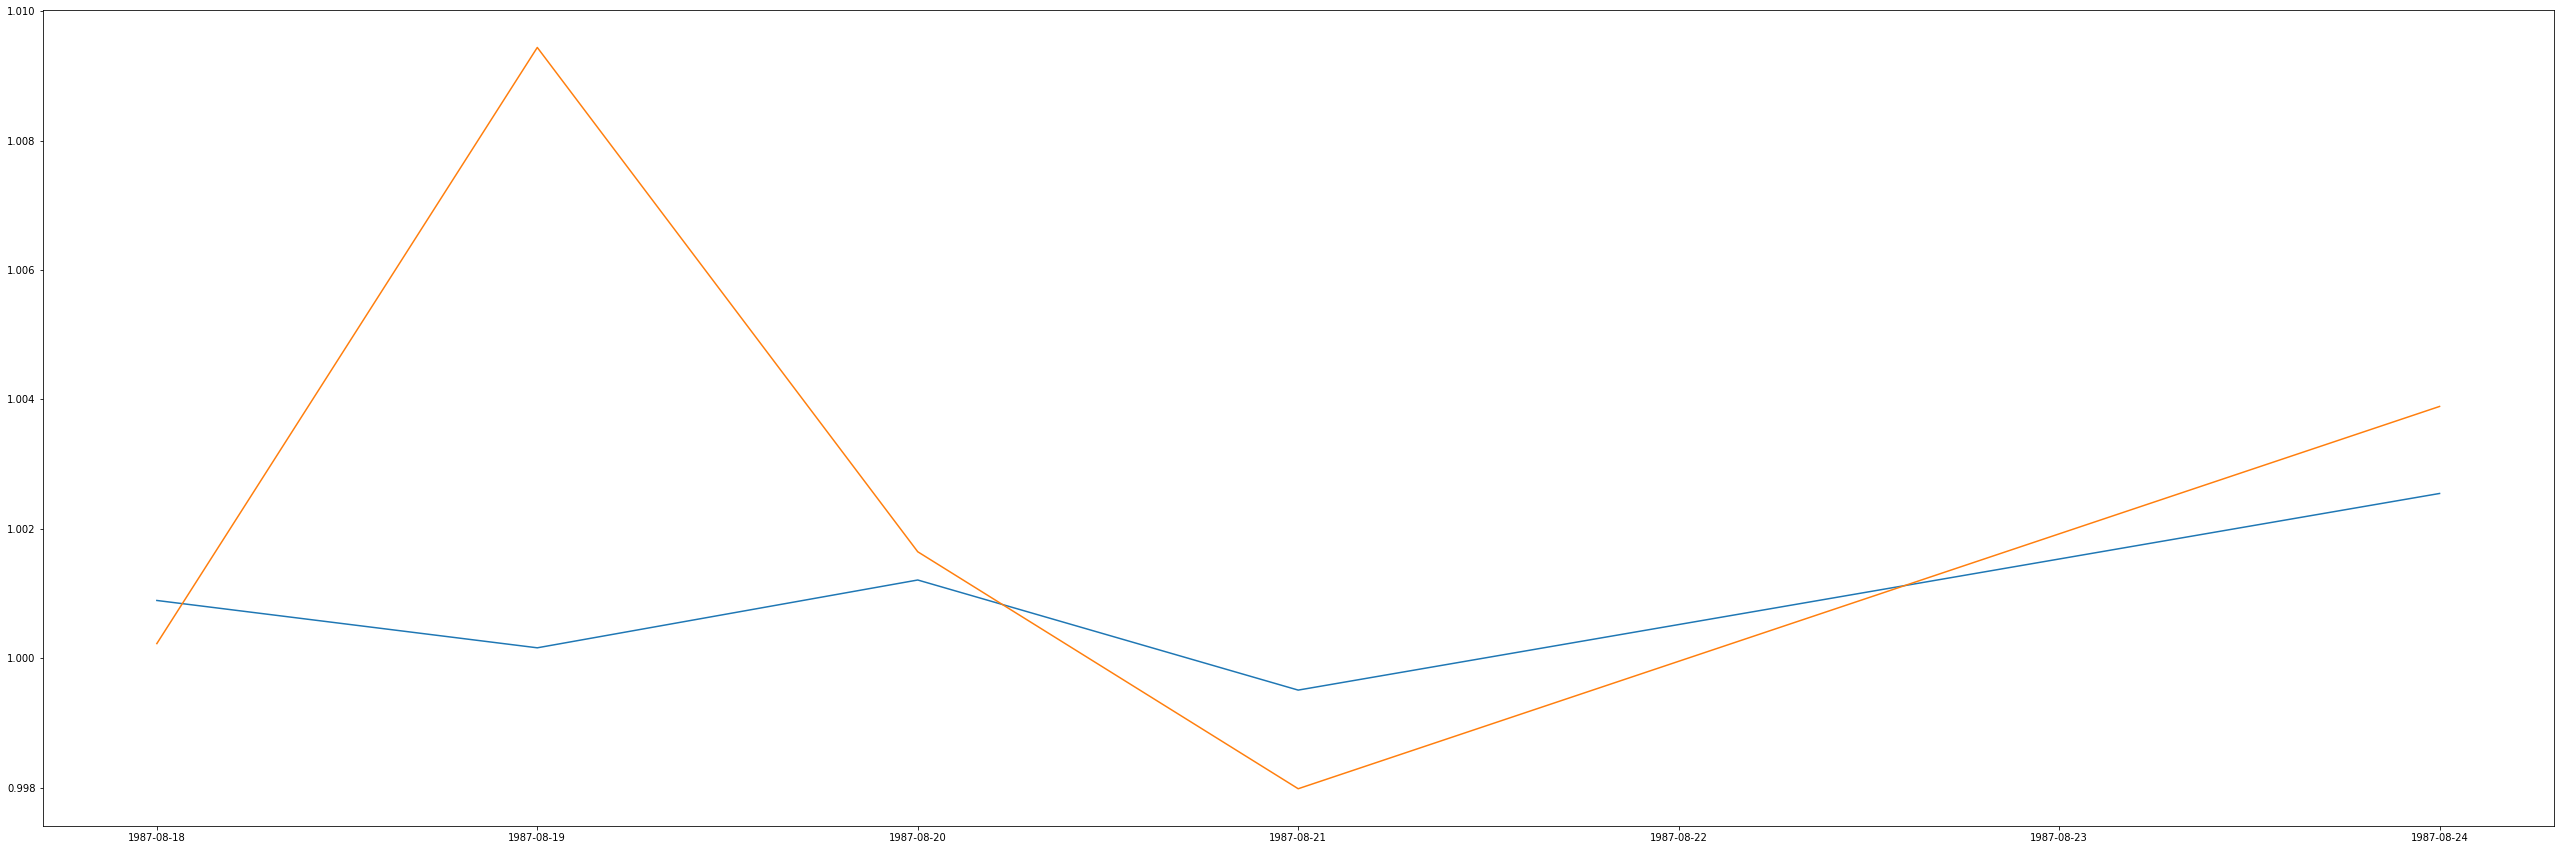

In [138]:
plt.figure(figsize=(45,15))
plt.plot(forecast_df)
plt.plot(y_test)
plt.show()